# AudioProtoPNet Inference Tutorial

Welcome to the **AudioProtoPNet** inference tutorial! This notebook shows you how to perform audio classification using pre-trained [AudioProtoPNet](https://github.com/DBD-research-group/AudioProtoPNet) models. These models are trained to identify bird species from audio recordings.

## About AudioProtoPNet Models
AudioProtoPNet is a prototype-based neural network architecture. Here, each class in the dataset has a specified number of prototypes that help the model discern audio features relevant to identifying that class.

There are four variants of AudioProtoPNet models:
- **AudioProtoPNet-1**: 1 prototype per class (9,736 total prototypes)
- **AudioProtoPNet-5**: 5 prototypes per class (48,680 total prototypes)
- **AudioProtoPNet-10**: 10 prototypes per class (97,360 total prototypes)
- **AudioProtoPNet-20**: 20 prototypes per class (194,720 total prototypes)

In this notebook, we demonstrate how to load the model, preprocess audio data, and generate predictions. **By default, we now use** AudioProtoPNet-20, but you can switch to any of the four variants by adjusting the relevant checkpoint path and number of prototypes.

For further insights into the model’s architecture and evaluation, please refer to the original research paper available [here](https://www.sciencedirect.com/science/article/pii/S1574954125000901).

## Key Points in This Tutorial
1. **Resampling**: We standardize audio to a 32 kHz sampling rate.
2. **Spectrogram Generation**: We convert the audio wave into a spectrogram using short-time Fourier transform (STFT) and Mel scaling.
3. **Normalization (z-standardization)**: We subtract a mean and divide by a standard deviation, calculated from the training data.
4. **Model Flexibility**: Although the model was trained on 5-second clips, it can be applied to audio of arbitrary length.

> **Important**: The spectrogram parameters shown here must be used **exactly** (e.g., `n_fft`, `hop_length`, `n_mels`, `n_stft`, and the standardization values). Changing these parameters can lead to performance degradation.

Let's get started!

## Package Versions Used in This Notebook

Below are the main packages and versions used in this tutorial:

- **librosa**: 0.10.0
- **numpy**: 1.24.4
- **torch**: 2.3.1
- **torchaudio**: 2.3.1
- **matplotlib**: 3.7.2
- **ipython**: 8.25.0
- **datasets**: 2.18.0
- **birdset**: 0.2.0
- **huggingface_hub**: 0.24.6


### Import necessary Python packages and modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%capture
# Here we import all necessary libraries:
# - librosa and torchaudio for audio processing
# - numpy and torch for numerical computation
# - matplotlib for plotting
# - IPython.display for audio playback
# - hf_hub_download for pulling checkpoints directly from Hugging Face
# - our custom modules for dataset and model definitions

import librosa
import numpy as np
import torch
from torchaudio import transforms
import matplotlib.pyplot as plt
from IPython.display import Audio
import datasets
from audioprotopnet.modules.baselines.convnext import ConvNextClassifier
from audioprotopnet.modules.ppnet.ppnet import PPNet
from audioprotopnet.modules.checkpoint_loading import load_state_dict
from birdset.datamodule.components import augmentations
from huggingface_hub import hf_hub_download

### Choosing Your AudioProtoPNet Model Variant
Below, we define our model parameters. Notice that we currently have default values set for **AudioProtoPNet-20**. If you want to use a different variant (such as AudioProtoPNet-1, -5, or -10), simply change the `variant` variable below.

The appropriate Hugging Face repo name, checkpoint filename, and number of prototypes will be selected automatically.

Example:
```python
variant = 5  # can be 1, 5, 10, or 20
```

Then just run the cell to load everything!

### Set path variables for audio files and configure the model

In [3]:
# User selection for the AudioProtoPNet variant:
variant = 1  # Options: 1, 5, 10, or 20.

# Define a lookup that maps the variant to:
# - The HF repo name
# - The checkpoint filename
# - The total number of prototypes
variant_to_info = {
    1: {
        "ckpt_repo": "DBD-research-group/AudioProtoPNet-1-BirdSet-XCL",
        "ckpt_filename": "AudioProtoPNet-1.ckpt",
        "num_prototypes": 9736
    },
    5: {
        "ckpt_repo": "DBD-research-group/AudioProtoPNet-5-BirdSet-XCL",
        "ckpt_filename": "AudioProtoPNet-5.ckpt",
        "num_prototypes": 48680
    },
    10: {
        "ckpt_repo": "DBD-research-group/AudioProtoPNet-10-BirdSet-XCL",
        "ckpt_filename": "AudioProtoPNet-10.ckpt",
        "num_prototypes": 97360
    },
    20: {
        "ckpt_repo": "DBD-research-group/AudioProtoPNet-20-BirdSet-XCL",
        "ckpt_filename": "AudioProtoPNet-20.ckpt",
        "num_prototypes": 194720
    }
}

# Retrieve the info for the chosen variant
chosen_info = variant_to_info[variant]
ckpt_repo = chosen_info["ckpt_repo"]
ckpt_filename = chosen_info["ckpt_filename"]
num_prototypes = chosen_info["num_prototypes"]

print(f"You have selected AudioProtoPNet-{variant}.")
print(f"HuggingFace Repo: {ckpt_repo}")
print(f"Checkpoint Filename: {ckpt_filename}")
print(f"Number of Prototypes: {num_prototypes}")

# We define the number of classes (n_classes=9736 for BirdSet)
n_classes = 9736  # number of classes (bird species)

# Instantiate the backbone model (ConvNeXt), which is our feature extractor.
backbone = ConvNextClassifier(
    num_classes=n_classes,
    num_channels=1,
    embedding_size=1024,        # Must match prototype_shape.channels.
    backbone_mode=True,
    checkpoint="facebook/convnext-base-224-22k",
    local_checkpoint=None,
    cache_dir=None,
    pretrain_info=None,
)

# The prototype shape must match our chosen number of prototypes.
prototype_shape = {
    "num_prototypes": num_prototypes,
    "channels": 1024,
    "height": 1,
    "width": 1,
}

# Instantiate the PPNet model using the backbone.
model = PPNet(
    backbone_model=backbone,
    prototype_shape=prototype_shape,
    num_classes=n_classes,
    topk_k=1,
    margin=None,
    init_weights=False,
    add_on_layers_type="upsample",
    incorrect_class_connection=None,
    correct_class_connection=1.0,
    bias_last_layer=-2.0,
    non_negative_last_layer=True,
    embedded_spectrogram_height=None,
    pretrain_info=None,
)

# Download the checkpoint from Hugging Face:
ckpt_path = hf_hub_download(repo_id=ckpt_repo, filename=ckpt_filename)

# Load the model weights from the checkpoint.
state_dict = load_state_dict(ckpt_path)
model.load_state_dict(state_dict, strict=True)

You have selected AudioProtoPNet-1.
HuggingFace Repo: DBD-research-group/AudioProtoPNet-1-BirdSet-XCL
Checkpoint Filename: AudioProtoPNet-1.ckpt
Number of Prototypes: 9736


C:\Users\mwirth\PycharmProjects\AudioProtoPNet\venv\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


>> Found a checkpoint. Loading..


<All keys matched successfully>

In [24]:
ebird_codes_list = datasets.load_dataset_builder("DBD-research-group/BirdSet", "XCL", trust_remote_code=True).info.features["ebird_code"]
id2label = dict(enumerate(ebird_codes_list.names))
label2id = dict(zip(list(id2label.values()), range(len(id2label))))

In [27]:
from hf_repo.modeling_protonet import AudioProtoNetForSequenceClassification
from hf_repo.configuration_protonet import AudioProtoNetConfig

In [28]:
state_dict = load_state_dict(ckpt_path)
state_dict = {k.replace("backbone_model.model.", "model.backbone."):v for k,v in state_dict.items()}
state_dict["head.last_layer.bias"] = state_dict["last_layer.bias"]
state_dict["head.last_layer.weight"] = state_dict["last_layer.weight"]
state_dict["head.prototype_vectors"] = state_dict["prototype_vectors"]
del state_dict["prototype_vectors"]
del state_dict["last_layer.weight"]
del state_dict["last_layer.bias"]

>> Found a checkpoint. Loading..


In [32]:
config = AudioProtoNetConfig(id2label=id2label, prototypes_per_class=variant, label2id=label2id)
hfmodel = AudioProtoNetForSequenceClassification(config)

In [33]:
hfmodel.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

In [34]:
hfmodel.save_pretrained(f"hf_repo/upload_{variant}")

### Note on Resampling to 32 kHz
The AudioProtoPNet models are trained on audio resampled to **32,000 Hz**. When using your own audio files, always ensure they are resampled to 32 kHz before feeding them into the model. Below, we show how to load and resample a built-in example audio (of a European Robin) in one step.

## Loading an Example Birdsong

#### Load the audio file

In [4]:
# 'librosa.ex' loads a built-in example audio of a European Robin.
sample_rate = 32000
audio_path = librosa.ex('robin')

label = "eurrob1"  # The eBird label for the European Robin.

# Load the audio file into 'audio' with our chosen sample_rate of 32 kHz.
audio, sample_rate = librosa.load(audio_path, sr=sample_rate)
Audio(audio, rate=sample_rate)

In [10]:
from transformers import AutoConfig, AutoFeatureExtractor, AutoModelForSequenceClassification, AutoModel

In [36]:
config = AutoConfig.from_pretrained("hf_repo/upload_1", trust_remote_code=True)
feature_extractor = AutoFeatureExtractor.from_pretrained("hf_repo/upload_1", trust_remote_code=True)
hfmodel = AutoModelForSequenceClassification.from_config(config, trust_remote_code=True)

In [45]:
hfmodel = AutoModelForSequenceClassification.from_pretrained("hf_repo/upload_1", trust_remote_code=True)

In [15]:
model = AutoModel.from_pretrained("hf_repo/upload_1", trust_remote_code=True)

In [ ]:
model

In [41]:
hfmodel

AudioProtoNetForSequenceClassification(
  (model): AudioProtoNetModel(
    (backbone): ConvNextModel(
      (embeddings): ConvNextEmbeddings(
        (patch_embeddings): Conv2d(1, 128, kernel_size=(4, 4), stride=(4, 4))
        (layernorm): ConvNextLayerNorm()
      )
      (encoder): ConvNextEncoder(
        (stages): ModuleList(
          (0): ConvNextStage(
            (downsampling_layer): Identity()
            (layers): Sequential(
              (0): ConvNextLayer(
                (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
                (layernorm): ConvNextLayerNorm()
                (pwconv1): Linear(in_features=128, out_features=512, bias=True)
                (act): GELUActivation()
                (pwconv2): Linear(in_features=512, out_features=128, bias=True)
                (drop_path): Identity()
              )
              (1): ConvNextLayer(
                (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), p

In [281]:
features = feature_extractor(audio)

In [282]:
out = hfmodel(features, labels=torch.tensor([0]*9736).unsqueeze(0), output_prototypical_activations=True, output_hidden_states=True)

In [285]:
predicted_id = out["logits"].argmax(dim=-1).item()

In [286]:
hfmodel.config.id2label[predicted_id]

'greflo1'

In [283]:
print(out["logits"])

tensor([[-0.8586, -0.4586,  0.3335,  ..., -0.0018, -0.4406, -0.0837]],
       grad_fn=<AsStridedBackward0>)


In [ ]:
# tensor([[-2.2634, -2.0364, -2.3784,  ..., -1.7601, -2.4846, -2.4871]],
#        grad_fn=<AsStridedBackward0>)


#### Visualizing the Audio Waveform

In [ ]:
librosa.display.waveshow(y=audio, sr=sample_rate)
plt.title(label)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (normalized)')
plt.show()

## Converting the Audio Signal into a Spectrogram

In order to use the AudioProtoPNet model, we must convert the raw audio waveform into a Mel-scaled spectrogram. The steps we use are:

1. **Spectrogram Transformation** (`transforms.Spectrogram`):
   - Uses STFT with a specific `n_fft` (window size) and `hop_length` (stride).
2. **Mel Scaling** (`transforms.MelScale`):
   - Converts frequencies to the Mel scale.
3. **dB Conversion** (`augmentations.PowerToDB()`):
   - Applies a logarithmic transform to the power spectrogram.
4. **Z-Standardization**:
   - We subtract a mean and divide by a standard deviation. These values (`mean` and `std`) come from the training data statistics.

Although the AudioProtoPNet was trained on 5-second clips, **you can use audio of any length**. Just note that the model processes the entire spectrogram.

> **Warning**: The parameters for preprocessing below (e.g., `n_fft=2048`, `hop_length=256`, `n_mels=256`, `n_stft=1025`, `mean=-13.369`, `std=13.162`) **must** be used. Changing them may result in decreased performance.

In [5]:
# Below are the parameters used for spectrogram generation.
# - n_fft=2048: Window size for STFT
# - hop_length=256: Step between windows
# - n_mels=256: Number of Mel frequency bins
# - n_stft=1025: The number of FFT bins used internally by MelScale
# - sample_rate=32000: Our target sampling rate
# 'mean' and 'std' are the training data statistics for z-standardization.
spec_transform = transforms.Spectrogram(n_fft=2048, hop_length=256, power=2.0)
mel_scale = transforms.MelScale(n_mels=256, sample_rate=32000, n_stft=1025)
db_scale = augmentations.PowerToDB()
mean = -13.369
std = 13.162

In [6]:
# Perform the actual transformation to get a normalized spectrogram.
audio_tensor = torch.as_tensor(audio)
spec_gram = spec_transform(audio_tensor)
mel_spec = mel_scale(spec_gram)
mel_spec = db_scale(mel_spec)
mel_spec_norm = (mel_spec - mean) / std

#### Visualizing the Spectrogram

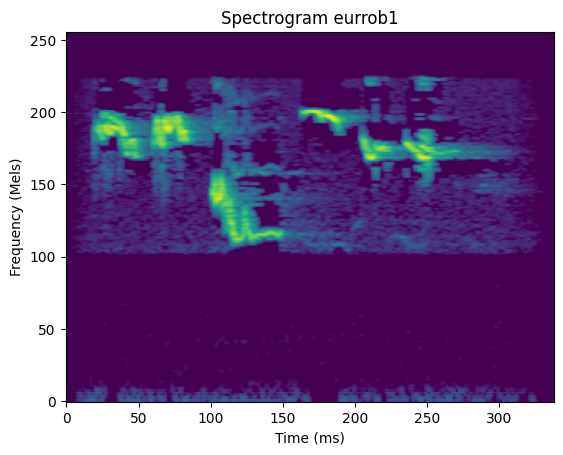

In [7]:
plt.imshow(mel_spec_norm, origin='lower')
plt.title('Spectrogram ' + label)
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Mels)')
plt.show()

## Classifying the Bird Species
Now that we have our preprocessed spectrogram, we can feed it into the model and obtain a prediction.

### Model Evaluation Mode

In [9]:
%%capture
# We set the model to evaluation mode,
# which turns off certain layers like dropout.
model.eval()
#hfmodel.eval()

#### Adjust the tensor dimensions for the model

In [13]:
# The model expects a batch of data. We add two dimensions:
# 1) a batch dimension
# 2) a channel dimension (we have 1 channel)
batch = mel_spec_norm.unsqueeze(0).unsqueeze(0)

#### Forward pass through the model

In [10]:
out = hfmodel(mel_spec_norm)

NameError: name 'hfmodel' is not defined

In [260]:
print(out["logits"])

tensor([[-2.2634, -2.0364, -2.3784,  ..., -1.7601, -2.4846, -2.4871]],
       grad_fn=<AsStridedBackward0>)


In [14]:
outputs = model(features)

In [15]:
print(outputs[0])

tensor([[-2.2634, -2.0364, -2.3784,  ..., -1.7601, -2.4846, -2.4871]],
       grad_fn=<AsStridedBackward0>)


#### Convert the model outputs to confidence scores

In [16]:
confidence_scores = torch.sigmoid(outputs[0])

#### Identifying the species class with the highest confidence score

In [17]:
prediction = np.argmax(confidence_scores.detach().numpy())
prediction

6583

#### Lookup the predicted bird species

In [18]:
ebird_codes_list = datasets.load_dataset_builder("DBD-research-group/BirdSet", "XCL", trust_remote_code=True).info.features["ebird_code"]
label_to_category_mapping = dict(enumerate(ebird_codes_list.names))
predicted_label = label_to_category_mapping[prediction]

In [19]:
print(f'Selected species: {label}')
print(f'Predicted species: {predicted_label}')

Selected species: eurrob1
Predicted species: sablar2


## Conclusion

In this tutorial, we:
1. Loaded a pre-trained AudioProtoPNet model (defaulting to AudioProtoPNet-20 in this example).
2. Resampled the audio to 32 kHz.
3. Converted the audio to a Mel-scaled spectrogram and applied z-standardization.
4. Obtained a bird species prediction from the model.

To adapt this notebook for your own data:
- Provide your own audio file path and ensure the audio is resampled to 32 kHz.
- **Use the same spectrogram transformation parameters** (`n_fft=2048`, `hop_length=256`, `n_mels=256`, `n_stft=1025`, `mean=-13.369`, and `std=13.162`). Changing them can degrade performance.
- Load the checkpoint of your preferred AudioProtoPNet variant.

We hope this tutorial gives you a clear understanding of how to use AudioProtoPNet for inference!